## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

In [40]:
import psycopg2
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
pd.set_option('display.max_columns', None)  #set pandas to display all columns

%matplotlib inline

conn = psycopg2.connect(database='mid_term_project',user='lhl_student',password='lhl_student', host='mid-term-project.ca2jkepgjpne.us-east-2.rds.amazonaws.com', port='5432')

print('Connection opened successfully')

Connection opened successfully


In [2]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tupples
    tupples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tupples, columns=column_names)
    return df

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

In [3]:
column_names = ['arr_delay']
delays = postgresql_to_dataframe(conn, 'SELECT arr_delay FROM flights', column_names)

In [4]:
print(delays.shape)
print(delays.mean())

(15927485, 1)
arr_delay    5.475932
dtype: float64


In [5]:
delays = delays.fillna(0)

In [6]:
delays_nooutliers = delays[(delays['arr_delay'] < 250)&(delays['arr_delay'] > -60)]

In [7]:
print(delays_nooutliers['arr_delay'].describe())
shapiro_test = stats.shapiro(delays_nooutliers['arr_delay'])
shapiro_test

count    1.583836e+07
mean     3.064837e+00
std      3.413541e+01
min     -5.900000e+01
25%     -1.500000e+01
50%     -6.000000e+00
75%      7.000000e+00
max      2.490000e+02
Name: arr_delay, dtype: float64


D:\Anaconda\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.7248700857162476, pvalue=0.0)

<AxesSubplot:xlabel='arr_delay', ylabel='Count'>

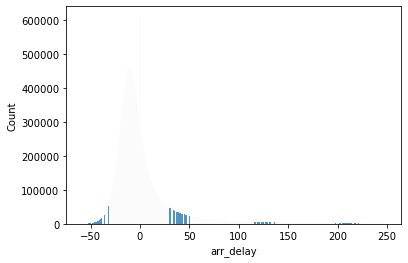

In [35]:
sns.histplot(data=delays_nooutliers, x='arr_delay')

Plot doesn't really show properly, it does appear to be a normal distribution centered around 0

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [9]:
column_names = ['date','delay']
delays = postgresql_to_dataframe(conn, 'SELECT fl_date, arr_delay FROM flights', column_names)
delays = delays.fillna(0)
delays['date'] = pd.to_datetime(delays['date'])
delays = delays.set_index('date')

In [10]:
median_delays_by_month = delays.groupby([(delays.index.year),(delays.index.month)]).median()
mean_delays_by_month = delays.groupby([(delays.index.year),(delays.index.month)]).mean()

In [41]:
mean_delays_by_month.T

date       2018                                                              \
date         1         2         3         4         5         6         7    
delay  3.174404  4.051883  2.053084  3.548852  5.882243  8.619621  8.786836   

date                                                         2019            \
date         8         9         10        11        12        1         2    
delay  9.840758  2.931579  3.033436  5.524317  3.660244  4.559447  8.985047   

date                                                                          \
date         3         4         5          6         7         8         9    
delay  3.412902  4.588739  6.865583  11.692696  8.755337  7.584691  0.467555   

date                                 
date         10        11        12  
delay  2.621728  0.453388  6.360014

In [42]:
median_delays_by_month.T

date  2018                                                        2019       \
date    1    2    3    4    5    6    7    8    9    10   11   12   1    2    
delay -8.0 -6.0 -6.0 -6.0 -5.0 -4.0 -4.0 -4.0 -7.0 -6.0 -5.0 -6.0 -6.0 -4.0   

date                                                     
date    3    4    5    6    7    8    9    10   11   12  
delay -6.0 -7.0 -5.0 -3.0 -5.0 -6.0 -8.0 -7.0 -8.0 -5.0

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [ ]:
from pandas import json_normalize
import os
import requests as re
import json
from IPython.display import JSON
import time
API_KEY = os.environ["VISUAL_CROSSING_API_KEY"]

In [ ]:
def get_weather(row):
    
    location = row['city']
    year = row['Year']
    month = row['Month']
    day = row['Day']
    hour = int(row['Hour']/100)
    date = f'{year}-{month}-{day}T{hour}:00:00'
    fs_url = f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{location}/{date}?key={API_KEY}&include=current'
    res = re.get(fs_url)
    weather = res.json()
    try:
        weather_at_time = weather['currentConditions']['conditions']
    except:
        weather_at_time = weather['days'][0]['conditions']
    return weather_at_time

#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

In [13]:
column_names = ['dep_time','arr_time','taxi_out','taxi_in']
taxi = postgresql_to_dataframe(conn, 'SELECT dep_time, arr_time, taxi_out, taxi_in FROM flights', column_names)

In [47]:
taxi_no_na = taxi.dropna()

In [56]:
taxi.shape

(15927485, 4)

In [55]:
taxi_no_na.shape

(15646311, 4)

In [49]:
dep_taxi = taxi_no_na[['dep_time','taxi_out']].copy(deep = True)
dep_taxi['dep_time'] = dep_taxi['dep_time'] / 100
dep_taxi['dep_time'] = dep_taxi['dep_time'].astype(int)
dep_taxi = dep_taxi.set_index('dep_time')

In [50]:
arr_taxi = taxi_no_na[['arr_time','taxi_in']].copy(deep = True)
arr_taxi['arr_time'] = arr_taxi['arr_time'] / 100
arr_taxi['arr_time'] = arr_taxi['arr_time'].astype(int)
arr_taxi = arr_taxi.set_index('arr_time')

In [51]:
dep_taxi_hourly_mean = dep_taxi.groupby(dep_taxi.index).mean()

In [52]:
arr_taxi_hourly_mean = arr_taxi.groupby(arr_taxi.index).mean()

In [53]:
dep_taxi_hourly_mean.T

dep_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
taxi_out,15.832357,14.592141,13.394658,12.54128,14.506214,16.025582,16.779315,17.779268,19.380408,18.493286,17.767804,17.233944,16.871219,16.646071,16.86035,17.610989,17.322199,17.849931,18.407493,17.591122,18.161761,17.612785,17.113212,16.613118,16.720984


In [54]:
arr_taxi_hourly_mean.T

arr_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
taxi_in,7.244766,7.14225,7.028483,6.988308,6.615069,7.093966,7.901549,7.892096,8.525365,8.081947,7.882279,7.290834,7.271266,7.262956,7.40267,7.369924,7.176246,7.703222,7.997614,8.468218,8.333433,7.952396,7.394409,6.930329,7.247988


#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

In [28]:
column_names = ['arr_delay','dep_delay']
arr_vs_dep_delay = postgresql_to_dataframe(conn, 'SELECT arr_delay, dep_delay FROM flights', column_names)

In [29]:
percentage_delays_bef_dep = arr_vs_dep_delay[arr_vs_dep_delay['arr_delay'] == arr_vs_dep_delay['dep_delay']].count() / arr_vs_dep_delay.count()

In [30]:
percentage_delays_bef_dep['arr_delay'] * 100

2.832494468242013

In [31]:
delays_decreased = arr_vs_dep_delay[arr_vs_dep_delay['arr_delay'] < arr_vs_dep_delay['dep_delay']].count() / arr_vs_dep_delay.count()

In [32]:
delays_decreased['arr_delay'] * 100

71.01194877655821

#### **Task 6**: How many states cover 50% of US air traffic? 

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?